In [1]:

from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#import torch
#import torch.nn as nn
from pylab import *
from numpy import *
import numpy as np
from PIL import Image
import math
import time
from random import random

In [2]:
from scipy.ndimage import geometric_transform
from scipy.ndimage import map_coordinates
def shift_func(coords,a,b,c,d):
 """ Define the mobius transformation, though backwards """
 #turn the first two coordinates into an imaginary number
 z = coords[0] + 1j*coords[1]
 w = (d*z-b)/(-c*z+a) #the inverse mobius transform
 #take the color along for the ride
 return real(w),imag(w),coords[2]


(32, 32, 3)


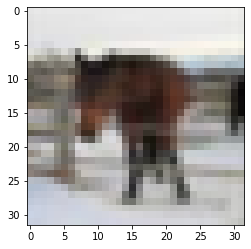

In [3]:
# Image attributes
img_path='horse.png'
img = Image.open(img_path).convert('RGB')
image = np.array(img)

print(image.shape)
height=image.shape[0]
width=image.shape[1]
imshow(image)

In [5]:
def drawpoints(image, point, color):
    h = point[0]
    w = point[1]
    where_to_draw = []
    where_to_draw.append(point)
    where_to_draw.append([h-1,w])
    where_to_draw.append([h+1,w])
    where_to_draw.append([h,w-1])
    where_to_draw.append([h,w+1])
    new_where_to_draw=[]
    for item in where_to_draw:
        if item[0]>=0 and item[0]<height and item[1]>=0 and item[1]<width:
            new_where_to_draw.append(item)

    for item in new_where_to_draw:
        if color == 'red':
            image[item[0],item[1]]=[255,102,102]
        elif color == 'green':
            image[item[0],item[1]]=[0,204,0]
        elif color == 'blue':
            image[item[0],item[1]]=[0,128,255]

In [6]:
def get_images(original_image,a,b,c,d,new_points,original_points):
    height=original_image.shape[0]
    width=original_image.shape[1]
    e=[complex(0,0)]*height*width
    z=np.array(e).reshape(height,width)

    for i in range(0,height):
        for j in range(0,width):
            z[i,j]=complex(i,j)


    r = ones((height, width,3),dtype=uint8)*255

    w = (a*z+b)/(c*z+d)

    first=real(w)*1
    second=imag(w)*1
    first=first.astype(int)
    second=second.astype(int)
    f1=first>=0
    f2=first<height
    f= f1 & f2
    s1=second>=0
    s2=second<width
    s= s1 & s2
    combined = s&f

    i=np.array(list(range(0,height))*width).reshape(width,height).T
    j=np.array(list(range(0,width))*height).reshape(height,width)
    r[first[combined],second[combined],:]=original_image[i[combined],j[combined],:]



    start = time.time()
    r2 = geometric_transform(original_image,shift_func,cval=0,order = 3,output_shape=(height,width,3),mode='constant',extra_arguments=(a,b,c,d))
    end = time.time()
    print('Time to get interpolation:', end - start)
    drawpoints(r2, new_points[0], 'red')
    drawpoints(r2, new_points[1], 'green')
    drawpoints(r2, new_points[2], 'blue')

    drawpoints(original_image, original_points[0], 'red')
    drawpoints(original_image, original_points[1], 'green')
    drawpoints(original_image, original_points[2], 'blue')

    drawpoints(r, new_points[0], 'red')
    drawpoints(r, new_points[1], 'green')
    drawpoints(r, new_points[2], 'blue')

    figure(figsize=(15, 10))
    subplot(1,3,1)
    title('Original')
    imshow(original_image)
    subplot(1,3,2)
    title('No interpolation')
    imshow(r)
    subplot(1,3,3)
    title('With interpolation')
    imshow(r2)

In [32]:
def M_admissable(a,b,c,d):
    M=3

    v1 = np.absolute(a) ** 2 / np.absolute(a*d - b*c)
    if not (v1 < M and v1 > 1/M):
        return False

    v2 = np.absolute(a-32*c) ** 2 / (np.absolute(a*d -b*c))
    if not (v2 < M and v2 > 1/M):
        return False

    v3 = np.absolute(complex(a,-32*c)) ** 2 / np.absolute(a*d-b*c)
    if not (v3 < M and v3 > 1/M):
        return False

    v4 = np.absolute(complex(a-32*c,-32*c)) ** 2 / np.absolute(a*d-b*c)
    if not (v4 < M and v4 > 1/M):
        return False
    
    v5 = np.absolute(complex(a-16*c,-16*c)) ** 2 / (np.absolute(a*d-b*c))
    if not (v5 < M and v5 > 1/M):
        return False

    v6 = np.absolute(complex(16*d-b,16*d)/complex(a-16*c,-16*c)-complex(16,16))
    if not( v6 < 8):
        return False
    
    
    return  True
        


    

In [9]:
zp=[complex(height*random(),width*random()), complex(height*random(),width*random()),complex(height*random(),width*random())] 
wa=[complex(height*random(),width*random()), complex(height*random(),width*random()),complex(height*random(),width*random())]

original_points = np.array([[real(zp[0]),imag(zp[0])],
                            [real(zp[1]),imag(zp[1])],
                            [real(zp[2]),imag(zp[2])]],dtype=int)
new_points = np.array([[real(wa[0]),imag(wa[0])],
                            [real(wa[1]),imag(wa[1])],
                            [real(wa[2]),imag(wa[2])]],dtype=int)
# transformation parameters
a = linalg.det([[zp[0]*wa[0], wa[0], 1], 
                [zp[1]*wa[1], wa[1], 1], 
                [zp[2]*wa[2], wa[2], 1]]);

b = linalg.det([[zp[0]*wa[0], zp[0], wa[0]], 
                [zp[1]*wa[1], zp[1], wa[1]], 
                [zp[2]*wa[2], zp[2], wa[2]]]);         


c = linalg.det([[zp[0], wa[0], 1], 
                [zp[1], wa[1], 1], 
                [zp[2], wa[2], 1]]);

d = linalg.det([[zp[0]*wa[0], zp[0], 1], 
                [zp[1]*wa[1], zp[1], 1], 
                [zp[2]*wa[2], zp[2], 1]]);


Time to get interpolation: 0.03139662742614746


False

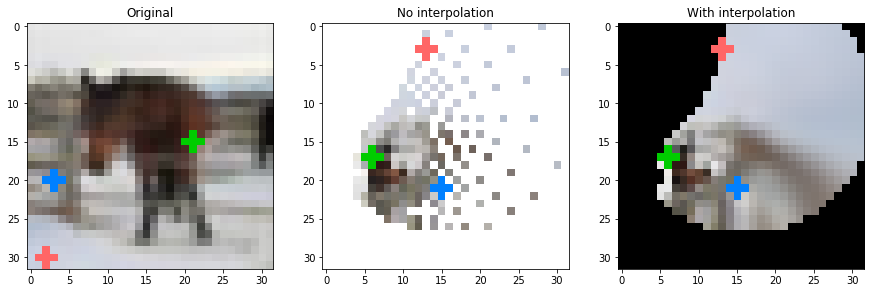

In [10]:
oringial_image = image.copy()
get_images(oringial_image,a,b,c,d,new_points,original_points)
M_admissable(a,b,c,d)

Time to get interpolation: 0.01845860481262207


True

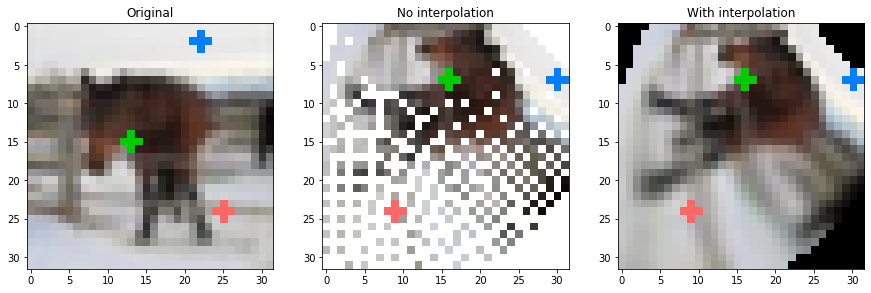

In [43]:
test=False #finding true ones
while test==False:
    zp=[complex(height*random(),width*random()), complex(height*random(),width*random()),complex(height*random(),width*random())] 
    wa=[complex(height*random(),width*random()), complex(height*random(),width*random()),complex(height*random(),width*random())]

    original_points = np.array([[real(zp[0]),imag(zp[0])],
                            [real(zp[1]),imag(zp[1])],
                            [real(zp[2]),imag(zp[2])]],dtype=int)
    new_points = np.array([[real(wa[0]),imag(wa[0])],
                            [real(wa[1]),imag(wa[1])],
                            [real(wa[2]),imag(wa[2])]],dtype=int)
    # transformation parameters
    a = linalg.det([[zp[0]*wa[0], wa[0], 1], 
                [zp[1]*wa[1], wa[1], 1], 
                [zp[2]*wa[2], wa[2], 1]]);

    b = linalg.det([[zp[0]*wa[0], zp[0], wa[0]], 
                [zp[1]*wa[1], zp[1], wa[1]], 
                [zp[2]*wa[2], zp[2], wa[2]]]);         


    c = linalg.det([[zp[0], wa[0], 1], 
                [zp[1], wa[1], 1], 
                [zp[2], wa[2], 1]]);

    d = linalg.det([[zp[0]*wa[0], zp[0], 1], 
                [zp[1]*wa[1], zp[1], 1], 
                [zp[2]*wa[2], zp[2], 1]]);
    test=M_admissable(a,b,c,d)
oringial_image = image.copy()
get_images(oringial_image,a,b,c,d,new_points,original_points)
M_admissable(a,b,c,d)

Time to get interpolation: 0.027300119400024414


False

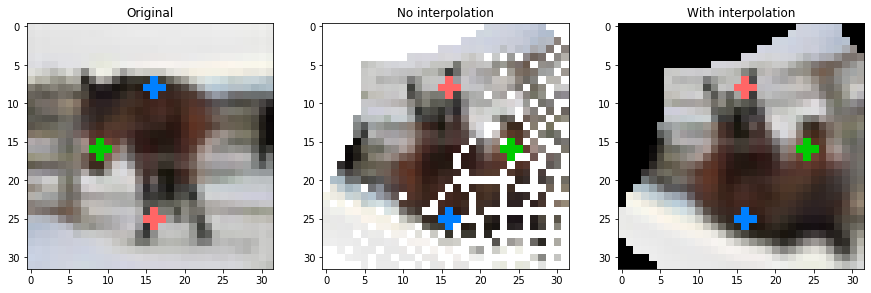

In [20]:
#trying to mimic the false negative
zp=[complex(height*0.8,width*0.5), complex(height*0.5,width*0.3), complex(height*0.25,width*0.5)] 
wa=[complex(height*0.25,width*0.5), complex(height*0.5,width*0.75), complex(height*0.8,width*0.5)]

original_points = np.array([[real(zp[0]),imag(zp[0])],
                            [real(zp[1]),imag(zp[1])],
                            [real(zp[2]),imag(zp[2])]],dtype=int)
new_points = np.array([[real(wa[0]),imag(wa[0])],
                            [real(wa[1]),imag(wa[1])],
                            [real(wa[2]),imag(wa[2])]],dtype=int)
# transformation parameters
a = linalg.det([[zp[0]*wa[0], wa[0], 1], 
                [zp[1]*wa[1], wa[1], 1], 
                [zp[2]*wa[2], wa[2], 1]]);

b = linalg.det([[zp[0]*wa[0], zp[0], wa[0]], 
                [zp[1]*wa[1], zp[1], wa[1]], 
                [zp[2]*wa[2], zp[2], wa[2]]]);         


c = linalg.det([[zp[0], wa[0], 1], 
                [zp[1], wa[1], 1], 
                [zp[2], wa[2], 1]]);

d = linalg.det([[zp[0]*wa[0], zp[0], 1], 
                [zp[1]*wa[1], zp[1], 1], 
                [zp[2]*wa[2], zp[2], 1]]);
    
    
oringial_image = image.copy()
get_images(oringial_image,a,b,c,d,new_points,original_points)
M_admissable(a,b,c,d)

True

In [128]:
np.absolute(a-32*c) ** 2 / (np.absolute(a*d -b*c)) # just a bit complex syntax test below

1.1372461573103794

In [129]:
a

(1351.6799999999992+9.003997547551982e-13j)

In [130]:
np.absolute(complex(a,-32*c))

2426.3398555025237

In [106]:
c

(-28.159999999999993+28.16000000000008j)

In [112]:
aa=complex(0,1)
cc=complex(2,3)

In [113]:
complex(0,cc)

(-3+2j)

In [115]:
np.absolute(32*c+a*complex(0,1))

2426.3398555025237